## Trabajo 1: Solución lineal de sistemas lineales en Julia

* Objetivo:Comparar diferentes métodos de resolución de sistemas lineales de gran tamaño con un problema de EDP que genera matrices no simétricas en base a los parámetros N, α y ε=1

$$\beta \cdot \bigtriangledown u-\epsilon \bigtriangleup u=0 $$

$$ \beta =\alpha (\frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2})^T $$

Contenido: utilizar el código en python (basado en el código Matlab de A. Meister, Aufgabe 6) y las librerías Julia de C.T. Kelley en https://github.com/ctkelley

Metodología: realizar un notebook de jupyter en Julia con gráficas y tablas de errores y tiempos de cómputo en base a las iteraciones

In [274]:
aux=false
if aux==true
    import Pkg
    Pkg.add("IterativeSolvers")
    Pkg.add("LinearAlgebra")
    Pkg.add("SparseArrays")
    Pkg.add("BenchmarkTools")
end

In [275]:
using LinearAlgebra
using SparseArrays
function Tarea1(N,a,b,tol,maxit)
    dx = 1 / (N + 1);

    e = ones(N);
    Dxx = spdiagm(-1 => e[1:N-1] , 0 => -2 * e  , 1 => e[1:N-1]);   # 1D central difference

    ident = Matrix{Float64}(I, N, N);
    x = kron(ident, Dxx) / (dx^2);  # 2nd derivative with respect to x

    Axx = kron(ident, Dxx) / (dx^2); # 2nd derivative with respect to x
    Ayy = kron(Dxx, ident) / (dx^2);  # 2nd derivative with respect to y

    Dx = spdiagm( -1 => e[1:N-1] , 1 => e[1:N-1]);  # 1D central difference
    Ax = kron(ident, Dx) / (2 * dx);

    I_2 = sparse(Matrix{Float64}(I, N*N, N*N));

    A = -Axx - Ayy - a * Ax - b * I_2;  # Matrix
    B = ones(N * N);  # Right-hand side
    u0 = 0.5 * ones(N * N);  # Initial guess

    return A, B, u0;
end

Tarea1 (generic function with 1 method)

1. Utilizar métodos directo LU y Choleski para matrices simétricas, y los métodos iterativos CG, BiCG , BiCGStab , GMRES , LGMRES, MINRES, QMR que encuentren en las librerías de Julia. Si encuentran otros , los aportan

Metodos directos:

In [341]:
 import LinearAlgebra
 using BenchmarkTools

 N=2; a=9 ; b=2 ; tol=1e-6 ; maxit=100000 ;
 A,b,u0 = Tarea1(N,a,b,tol,maxit);
# #Calcular descomposicion LU
A
 lu_decomposition = lu(A);
 L = lu_decomposition.L;U = lu_decomposition.U;P = lu_decomposition.p;
#cholesky
# using LinearAlgebra

L_cholesky= cholesky(A);



# #Metodos Iterativos
# using IterativeSolvers
# #CG
# tcg = @elapsed begin
#     xcg,hcg=cg(A,b,log=true,maxiter=maxit);
# end
# #bicgstab
# tbicgstab = @elapsed begin
#     xbicgstabl,hbicgstabl=bicgstabl(A,b,log=true)
# end
# #gmres
# tgmres = @elapsed begin
#     xgmres,hgmres=gmres(A,b,log=true,maxiter=maxit);
# end

# #minres
# tminres = @elapsed begin
#     xminres,hminres = minres(A,b,log=true,maxiter=maxit);   
# end

# #qmr
# tqmr = @elapsed begin
#     xqmr,hqmr=qmr(A,b,log=true,maxiter=maxit);    
# end

# #using KrylovKit
# #BiCG
# #xbicg,hbicg=bicg(A,b)

# #LGMRESusing
# #xlgmres,hgmres=lgmres(A,b,log=true)

SparseArrays.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  9
nnz:     9
success: true


2. Utilizar escenarios de N y α en base a la presentación . Utilizar el mayor N possible con tiempos esperables menos de una hora).

In [342]:
using IterativeSolvers
using BenchmarkTools
# Parameters
a = 2;   # Advection parameter
b = 4;     # Reaction parameter
tol = 1e-6;    # Tolerance for stopping criterion
maxit = 100000;  # Maximum number of iterations
n=[40,80,120,160];

XCG=[]        ; HCG=[]       ; TCG=[]       ;
XBICGSTAB=[]  ; HBICGSTAB=[] ; TBICGSTAB=[] ;
XGMRES=[]     ; HGMRES=[]    ; TGMRES=[]    ;
XMINRES=[]    ; HMINRES=[]   ; TMINRES=[]   ;
XQMR=[]       ; HQMR=[]      ; TQMR=[]      ;
N_data=[]     ; T_N=[];

 for N in n
    A,B,u0 = Tarea1(N,a,b,tol,maxit);

    #CG
    tcg = @elapsed begin
        xcg , hcg = cg(A,B,log=true,maxiter=maxit);
    end
    push!(XCG,xcg) ; push!(HCG,hcg); push!(TCG,tcg);

    #bicgstab
    tbicgtab = @elapsed begin
      xbicgstab , hbicgstab = bicgstabl(A,B,log=true);
    end
    push!(XBICGSTAB,xbicgstab) ; push!(HBICGSTAB,hbicgstab); push!(TBICGSTAB,tbicgtab);

    #gmres
    tgmres = @elapsed begin
      xgmres , hgmres = gmres(A,B,log=true);  
    end
    push!(XGMRES,xgmres) ; push!(HGMRES,hgmres); push!(TGMRES,tgmres);
    
    #minresgi
    tminres = @elapsed begin
      xminres , hminres = minres(A,B,log=true);  
    end
    push!(XMINRES,xminres) ; push!(HMINRES,hminres); push!(TMINRES,tminres);
    
    #qmr
    tqmr = @elapsed begin
      xqmr , hqmr = qmr(A,B,log=true);  
    end
    push!(XQMR,xqmr) ; push!(HQMR,hqmr); push!(TQMR,tqmr);

    #N
    aux=vcat(hcg,hbicgstab,hgmres,hminres,hqmr)
    push!(N_data,aux);
    
 end

# Ordenado por cada N

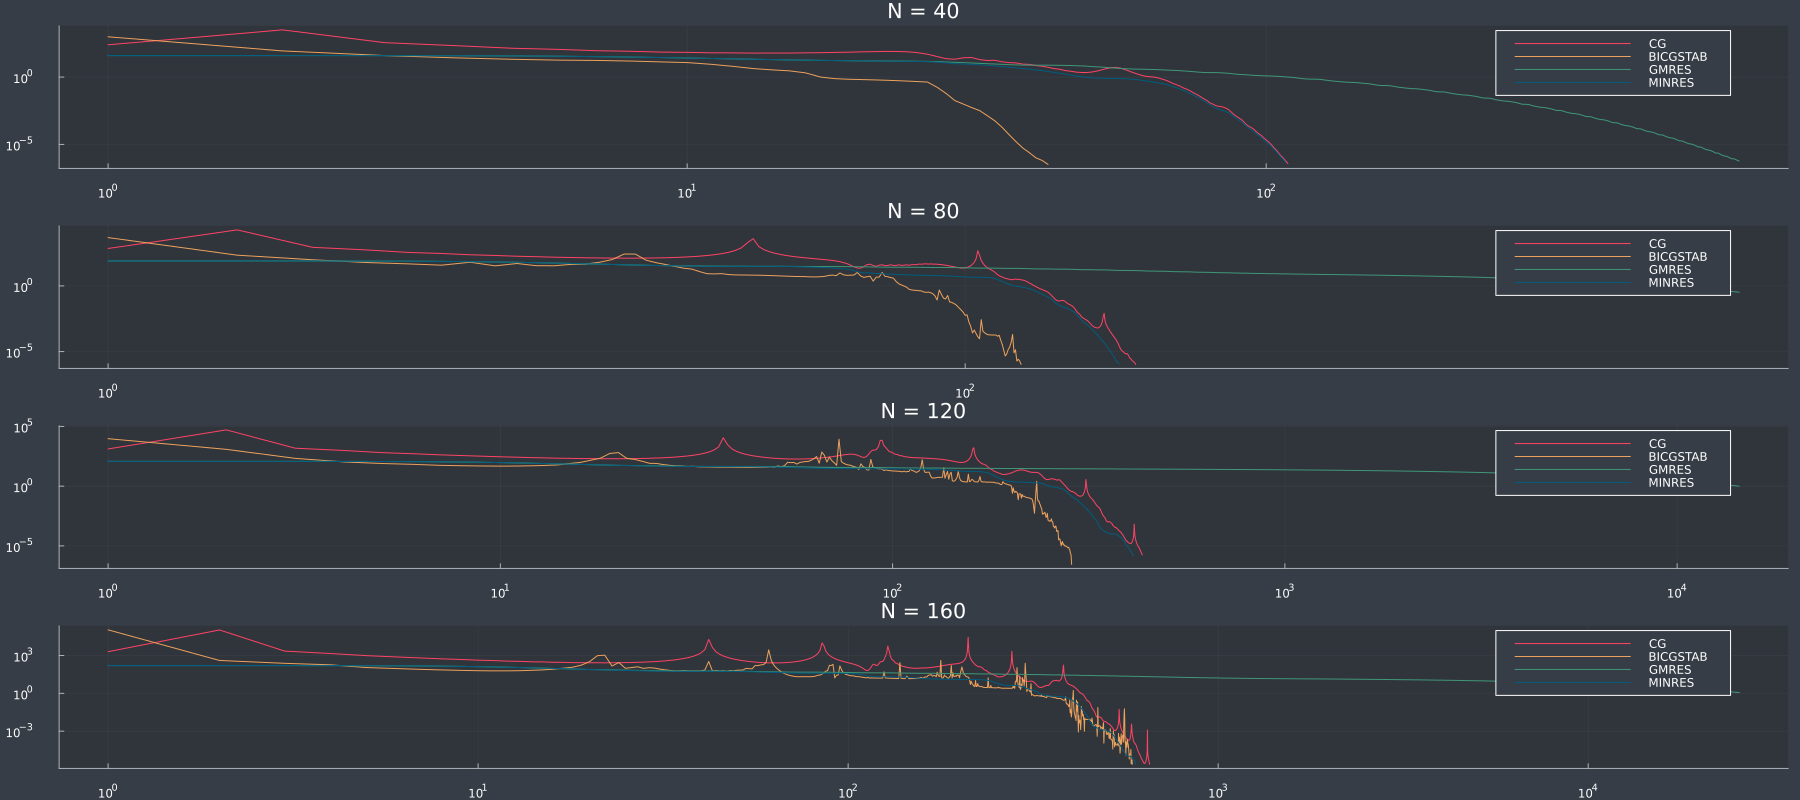

In [349]:
using Plots
theme(:dark)
nombres=["CG       ","BICGSTAB ","GMRES    ","MINRES   ","QMR      "];
tiempos =[ TCG , TBICGSTAB , TGMRES , TMINRES , TQMR ];
layout= @layout [a ; b ; c ; d ];
p=plot(layout=layout,size=(1800,800))


  for (i,metodo) in enumerate(N_data)
      nombre=nombres[i]; 
      for (j,valor) in enumerate(n)
          aux=nombres[j];
          aux2=n[i];

          nombre = nombres[j];
          label= "$nombre";
          
          x=[x for x in 1:length( metodo[j][:resnorm] )];
          y=metodo[j][:resnorm];
          plot!(p[i],x,y, xscale=:log10, yscale=:log10, label=label,title="N = $aux2")  
      end        
  end
 p

### Notas:
* A medida que aumenta el **N**, los metodos **CG** y **BiCGSTAB** se vuelven mas "turbulentos".
* El metodo **GMRES** a medida que aumenta el **N** tiende a demorar cada vez mas en relación a los otros metodos que "convergen" en zonas similares.
* En todos los **N** analizados, el metodo que mas rapido disminuye sus residuos en los procesos de iteración es **BiCGSTAB** y el que mas demora es **GMRES** y **MINRES**

# Ordenado por metodo

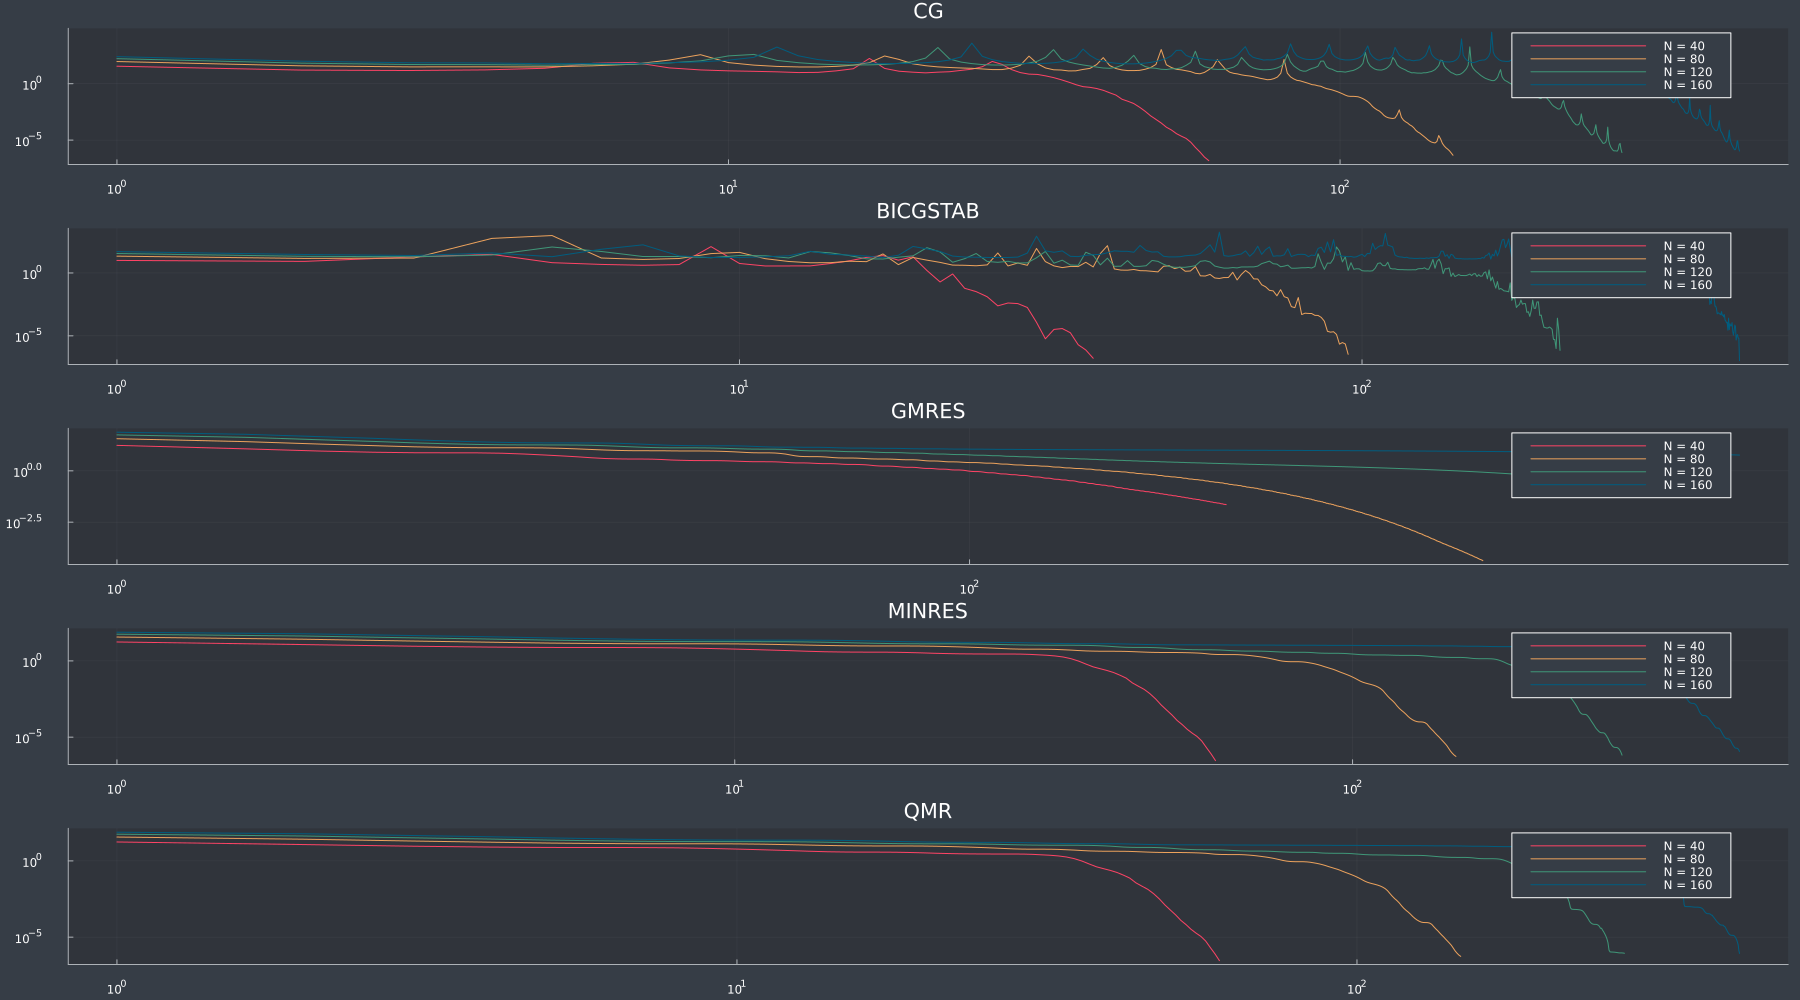

In [350]:
using Plots
theme(:dark)
metodos=[ NCG , NBICGSTAB , NGMRES , NMINRES , NQMR ];
nombres=["CG","BICGSTAB","GMRES","MINRES","QMR"];
layout= @layout [a ; b ; c ; d ; e];
p_N=plot(layout=layout,size=(1800,1000))


  for (i,metodo) in enumerate(metodos)
      nombre=nombres[i]; 
      for (j,valor) in enumerate(n)
          aux=n[j];
          label= "N = $aux";
          x=[x for x in 1:length( metodo[j][:resnorm] )];
          y=metodo[j][:resnorm];
          plot!(p_N[i],x,y, xscale=:log10, yscale=:log10, label=label,title="$nombre")  
      end        
  end
 p_N

### Notas:
* Se observa que los metodos **GMRES**, **MINRES** y **QMR**. Tienen un comportamiento mas "Suave" en las iteraciones que los metodos **CG** y **BiCGSTAB**.
* Para un **N = 40** el metodo **GMRES** termina de iterar antes que el resto. Pero con un residuo mayor que los demas y el mismo para otros **N**.
* Los metodos **CG** y **BiCGSTAB** se observan mas "turbulentos" que los otros pero aun asi estos llegan a un residuo similar que los demas metodos.

## Analisis de Tiempos

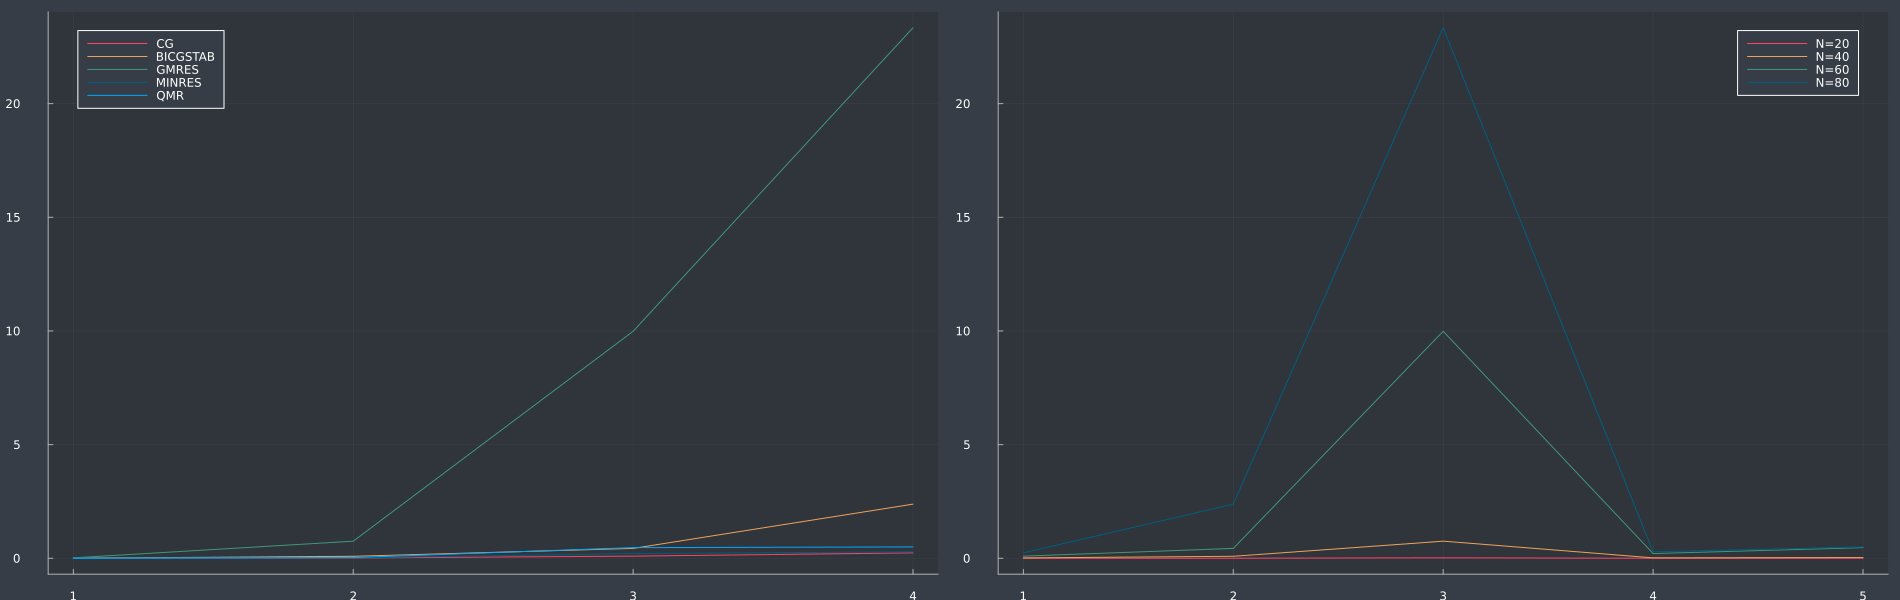

In [355]:
using Plots
theme(:dark)
tiempos=[ TCG , TBICGSTAB , TGMRES , TMINRES , TQMR ];
nombres=["CG" "BICGSTAB" "GMRES" "MINRES" "QMR"];
matrix_tiempos=hcat(tiempos[1], tiempos[2], tiempos[3], tiempos[4], tiempos[5])

ptime1=plot(matrix_tiempos,label=["CG" "BICGSTAB" "GMRES" "MINRES" "QMR"])
ptime2=plot(matrix_tiempos',label=["N=20" "N=40" "N=60" "N=80"])
plot(ptime1,ptime2,layout=@layout[a b],size=(1900,600))


### Notas: 

* Se observa que el metodo **GMRES** es el que mas demora a medida que el tamaño de la matrix aumenta en comparación a los otros metodos que si bien aumentan en comparación con ellos mismos, no es tan brusco el aumento del tiempo de calculo.
* Los metodos que mejor rendimiento tienen para distintos **N** son: **CG** y **BicGSTAB**. Esto porque su variación a medida que el **N** aumenta no varian mucho en comparación a **GMRES** y **MINRES**

## Apuntes:

**ConvergenceHistory keys**

- `:tol` => `::Real`: stopping tolerance.
- `:resnorm` => `::Vector`: residual norm at each iteration.
- `history.mvps`: number of matrix vector products.
- `history.mtvps`: number of transposed matrix-vector products
- `history.iters`: iterations taken by the method
- `history.isconverged`: convergence of the method.
- `history.data`:  Stores all the information stored during the method execution. It stores tolerances, residuals and other information.